# Import packages

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

import xarray as xr
import pandas as pd
import numpy as np
import yaml
import matplotlib.pyplot as plt

from utils.utils import (
    reduceDataByDay, calculate_and_plot_time_statistics
)
from camels_spat2nh import *

# Set display options for pandas
pd.set_option('display.max_columns', None)  # Set to None for unlimited columns or specify a number
# Now, when one displays xarray DataArrays or Datasets, the columns will be wider


# Get the current working directory of the notebook
CURRENT_DIR = os.getcwd()
# Add the parent directory of the notebook to the Python path
# root_dir = os.path.abspath(os.path.join(current_dir, '..', '..'))
ROOT_DIR = os.path.abspath(CURRENT_DIR)
sys.path.append(ROOT_DIR)



In [2]:
# Print packages version
print(f'xarray version: {xr.__version__}')
print(f'pandas version: {pd.__version__}')
print(f'numpy version: {np.__version__}')
print(f'yaml version: {yaml.__version__}')


xarray version: 2023.1.0
pandas version: 2.0.3
numpy version: 1.24.4
yaml version: 6.0.1


# Load Data

## Util data

In [3]:
data_dir, data_gen = load_util_data(CURRENT_DIR)

## Explore time-frame for usable basins

In [4]:
basins_dir = data_dir['data_dir_camels_spat_nh']
countries = data_gen['countries']

In [5]:
# Call the function to calculate statistics and plot histograms
time_stats = calculate_and_plot_time_statistics(basins_dir, countries)


In [ ]:
import math

# Load the DataFrame from the CSV file
file_path = os.path.join(basins_dir, f'camels_spat_1426_dates_stats.csv')
all_time_stats_df = pd.read_csv(file_path)

# Function to compute list of decades
def compute_decades_list(start_date, end_date):
    min_year = start_date.year
    max_year = end_date.year

    # Check if there is an incomplete decade at the end and adjust max_year
    if end_date.month < 1 or (end_date.month == 1 and end_date.day < 1):
        max_year -= 1

    # Calculate number of complete decades
    num_decades = math.floor((max_year - min_year) / 10)

    # Generate list of decades
    decades_list = [min_year + i * 10 for i in range(num_decades + 1)]
    return decades_list

# Find the extremes from 'Start Dates' and 'End Dates' columns
min_start_date = pd.to_datetime(all_time_stats_df['Start_date']).min()
max_end_date = pd.to_datetime(all_time_stats_df['End_date']).max()

# Compute the list of decades covered
decades_list = compute_decades_list(min_start_date, max_end_date)

print("List of decades covered:", decades_list)

List of decades covered: [1950, 1960, 1970, 1980, 1990, 2000, 2010]


In [ ]:
354 = a.uououou

SyntaxError: cannot assign to literal (1640588389.py, line 1)

## Process xarrays to csv

In [ ]:
# ## Let's profile the loop
# start_time = time.time()
# camels_spat2nh(data_dir, data_gen)
# ## End of process
# print('\n', f"--- {(time.time() - start_time):.2f} seconds ---")

## Tests

In [ ]:
# Define the path to the data directory file
data_dir_path = os.path.join(ROOT_DIR , "utils", "data_dir.yml")

with open(data_dir_path, 'r') as ymlfile:
    data_dir = yaml.load(ymlfile, Loader=yaml.FullLoader)
    
data_dir_src = data_dir['data_dir_camels_spat']
data_dir_out = data_dir['data_dir_camels_spat_nh']

In [ ]:
data_gen_path = os.path.join(ROOT_DIR , "utils", "data_general.yml")

with open(data_gen_path, 'r') as ymlfile:
    data_gen = yaml.load(ymlfile, Loader=yaml.FullLoader)
    
countries = data_gen['countries']
camels_spat_metadata = data_gen['camels_spat_metadata']
camels_spat_unusable = data_gen['camels_spat_unusable']
data_sources = data_gen['data_sources']

### Filter usable basins and create txt file

In [ ]:
# df_metadata = pd.read_csv(os.path.join(data_dir_src, camels_spat_metadata))
# df_unusable = pd.read_csv(os.path.join(data_dir_src, camels_spat_unusable))
df_metadata = pd.read_csv(os.path.join('data', camels_spat_metadata))
# df_unusable = pd.read_csv(os.path.join('data', camels_spat_unusable))

# # Create a dict to map the Country to a list of Station_id
# # Create a dictionary to map Country to a list of Station_id
# country_station_map = {}
# for index, row in df_metadata.iterrows():
#     country = row['Country']
#     station_id = row['Station_id']
#     if country in country_station_map:
#         country_station_map[country].append(station_id)
#     else:
#         country_station_map[country] = [station_id]

## Basin data

In [ ]:
file_name = 'camels_spat_metadata.csv'
# file_name = 'rhbn_stations.csv'
# Load data as pandas dataframe
df = pd.read_csv(os.path.join(data_dir_src, file_name), sep=',', header=0)
# Print first 5 rows
len(df)

1698

In [ ]:
basin_data_path = os.path.join(data_dir_src, 'basin_data')
list_basin_files = sorted(os.listdir(basin_data_path))

# Filter folders by country name (3 first letters) - create a dictionary
basin_data_path_dict = {}
for country in countries:
    basin_data_path_dict[country] = [basin for basin in list_basin_files if basin[:3] == country]
len(basin_data_path_dict['CAN']) + len(basin_data_path_dict['USA'])

4

In [ ]:
list_basin_files

['CAN_01AD002', 'CAN_01AD003', 'USA_01013500', 'USA_01022500']

In [ ]:
basin_data_path_dict[countries[0]]

['CAN_01AD002', 'CAN_01AD003']

Directory ../../../gladwell/hydrology/SUMMA/summa-ml-models/CAMELS_spat_NH/CAMELS_spat_CAN already exists
CAN
CAN_01AD002
null_values1 -> <xarray.DataArray 'q_obs' ()>
array(0)
min_date -> 1950-01-01T00:00:00.000000000
max_date -> 2020-12-31T00:00:00.000000000
Converting Target to DataFrame...
null_values2 -> 0
Empty DataFrame
Columns: [date, q_obs]
Index: []
CAN_01AD003
null_values1 -> <xarray.DataArray 'q_obs' ()>
array(0)
min_date -> 1951-10-01T00:00:00.000000000
max_date -> 2020-12-31T00:00:00.000000000
Converting Target to DataFrame...
null_values2 -> 0
Empty DataFrame
Columns: [date, q_obs]
Index: []
Directory ../../../gladwell/hydrology/SUMMA/summa-ml-models/CAMELS_spat_NH/CAMELS_spat_USA already exists
USA
USA_01013500
null_values1 -> <xarray.DataArray 'q_obs' ()>
array(9)
min_date -> 1950-01-01T00:00:00.000000000
max_date -> 2023-01-02T00:00:00.000000000
Converting Target to DataFrame...
null_values2 -> 9
            date  q_obs
26622 2022-11-21    NaN
26623 2022-11-22    NaN


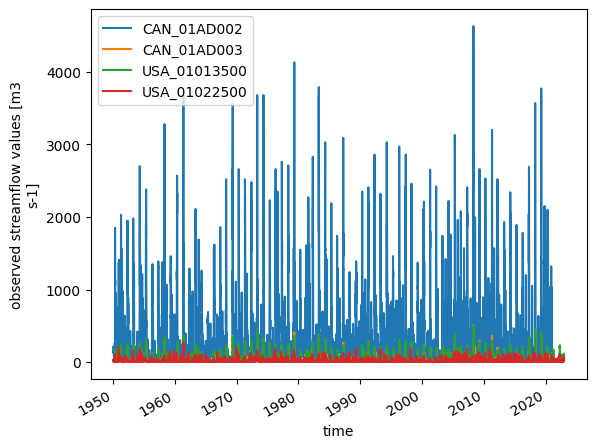

In [ ]:
relative_path_forc = data_dir['relative_path_forcing']
relative_path_targ = data_dir['relative_path_target']
for country in countries[:]:
    
    # Create a folder for each country
    country_dir = os.path.join(data_dir_out, f'CAMELS_spat_{country}')
    if not os.path.exists(country_dir ):
        os.makedirs(country_dir)
    else:
        print(f"Directory {country_dir} already exists")
        
    print(country)
    for basin_f in basin_data_path_dict[country][:]:
        print(basin_f)
        # ## Load input data
        # df_src_dict = {}
        # for src in data_sources:
        #     folder2load = os.path.join(basin_data_path, basin_f, relative_path_forc)
            
        #     eras_files = sorted([f for f in os.listdir(folder2load) if src in f])
        #     print(src, len(eras_files))

        #     # Initialize an empty list to store the xarray datasets
        #     datasets = []
        #     # Iterate over the files and load each dataset
        #     print("Loading Input datasets...")
        #     for file2load in eras_files[:50]:
        #         # If not .temp file
        #         if '.tmp' not in file2load:
        #             basin_data = xr.open_dataset(os.path.join(folder2load, file2load))
        #             datasets.append(basin_data)
                
        #     # Concatenate all datasets along the 'time' dimension
        #     print("Concatenating Input datasets...")
        #     concatenated_dataset = xr.concat(datasets, dim='time')
                
        #     # Reduce basin_data to daily values
        #     print("Reducing Input data to daily values...")
        #     basin_data_reduced = reduceDataByDay(concatenated_dataset, data_gen['input_vars'], data_gen['sum_vars'])
        #     # Convert the reduced basin_data to a DataFrame, dropping the 'hru' dimension
        #     print("Converting Input to DataFrame...")
        #     basin_data_df = basin_data_reduced.to_dataframe().droplevel('hru').reset_index()
            
        #     # Save to dict
        #     df_src_dict[src] = basin_data_df
            
        # # Merge dataframes in the dictionary
        # print("Merging Input DataFrames...")
        # df_merged_inp = df_src_dict[data_sources[0]].merge(df_src_dict[data_sources[1]], on='time')
        
        # # Rename time by date
        # df_merged_inp.rename(columns={'time': 'date'}, inplace=True)
        
        ## Load target data
        target_data = xr.open_dataset(os.path.join(basin_data_path, basin_f, relative_path_targ, f'{basin_f}_daily_flow_observations.nc'))
        
        display(target_data)
        
        aux = input("Press Enter to continue...")
        
        # Subset by data_gen['target_vars']
        target_data = target_data[data_gen['target_vars']]
        
        # Plot the target data
        target_data.q_obs.plot(label=basin_f)
        # Legend
        plt.legend(loc='upper left')
        
        # # Check if NULL values in the target data
        # null_values = target_data.isnull().sum()
        # print('null_values1 ->', null_values['q_obs'])
        
        # # Print min and max dates
        # print('min_date ->', target_data.time.min().values)
        # print('max_date ->', target_data.time.max().values)
        
        
        # Convert to DataFrame
        print("Converting Target to DataFrame...")
        df_target = target_data.to_dataframe().reset_index()
        # Rename time by date
        df_target.rename(columns={'time': 'date'}, inplace=True)
        # # drop column 'time_bnds' and remove duplicates
        # df_target.drop(columns=['time_bnds'], inplace=True)
        df_target = df_target.drop_duplicates(subset=['date'])
        
        # Check if NULL values in the target data
        null_values = df_target.isnull().sum()
        print('null_values2 ->', null_values['q_obs'])
        # Print dates that have q_obs NULL
        print(df_target[df_target['q_obs'].isnull()])
        
        # # Merge input and target dataframes
        # print("Merging Input and Target DataFrames...")
        # df_merged = df_merged_inp.merge(df_target, on='date')
        
        # # Save to file
        # print("Saving to file...")
        # df_merged.to_csv(os.path.join(country_dir, basin_f + '.csv'), index=False)
        
        

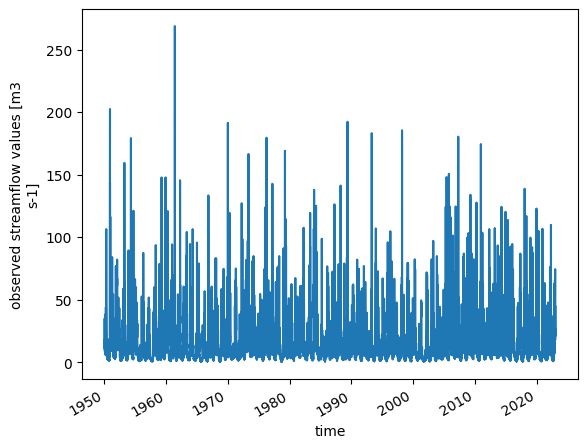

In [ ]:
target_data.q_obs

In [ ]:
df_merged.columns

Index(['date', 'e', 'mper', 'msdwlwrf', 'msdwswrf', 'msnlwrf', 'msnswrf',
       'mtpr', 'q', 'rh', 'sp', 't', 'u', 'v', 'w', 'phi', 'tmean', 'prcp',
       'q_obs'],
      dtype='object')

In [ ]:
list(basin_data.data_vars)

['latitude', 'longitude', 'hruId', 'tmean', 'prcp', 'time_bnds']

In [ ]:
folder2load = os.path.join(basin_data_path, basin_data_path_dict[countries[0]][0], 'observations')
file2load = basin_data_path_dict[countries[0]][0] + '_daily_flow_observations.nc'
basin_obs = xr.open_dataset(os.path.join(folder2load, file2load))
basin_obs

<xarray.Dataset>
Dimensions:                   (time: 25933, nbnds: 2)
Coordinates:
  * time                      (time) datetime64[ns] 1950-01-01 ... 2020-12-31
  * nbnds                     (nbnds) int32 1 2
Data variables:
    q_obs_data_quality        (time) object ...
    q_obs                     (time) float64 ...
    q_obs_is_ice_affected     (time) int32 ...
    q_obs_is_partial_day      (time) int32 ...
    q_obs_is_dry_day          (time) int32 ...
    q_obs_is_estimated_value  (time) int32 ...
    time_bnds                 (nbnds, time) datetime64[ns] ...
Attributes:
    title:        CAMELS-spat streamflow data
    conventions:  CF-1.10
    source:       Streamflow derived from observed water levels
    country:      CAN
    station:      01AD002
    institution:  Water Survey of Canada
    references:   Original data extracted from the Environment and Climate Ch...
    history:      2023-08-02 11:32:55 | File prepared using CAMELS-spat scrip...
    comment:      Water Survey of Canada calculates daily average flow values...

In [ ]:
variable_names = [var for var in list(basin_obs.variables.keys()) if 'obs' in var]
variable_names

['q_obs_data_quality',
 'q_obs',
 'q_obs_is_ice_affected',
 'q_obs_is_partial_day',
 'q_obs_is_dry_day',
 'q_obs_is_estimated_value']

Text(0.5, 1.0, 'q_obs')

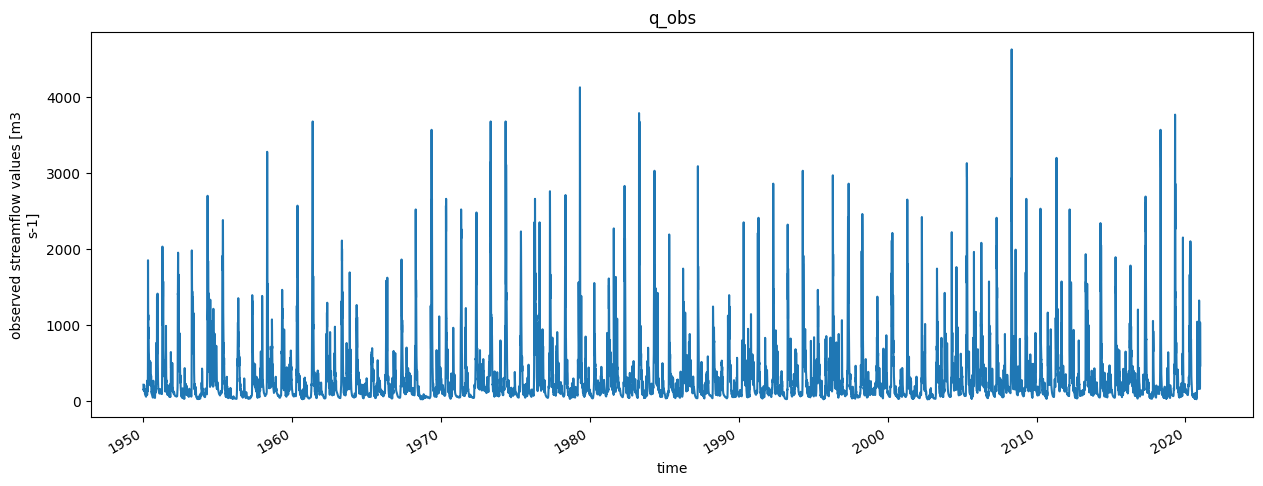

In [ ]:
var_to_plot = variable_names[1]
# Plot the data
basin_obs[var_to_plot].plot.line(hue='station_id', figsize=(15, 5))
plt.title(var_to_plot)